First of, install the requirements

In [1]:
!pip install -r requirements.txt

In [2]:
!python -m spacy download sv_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 13.7 MB/s eta 0:00:00a 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('sv_core_news_sm')


In [3]:
import os
import json
import pandas as pd

# Project Code for topic classification for Swedish parlament dataset

### Start of by creating a data frame out of the jsonl files

In [4]:
jsonl_files = [ "anforande-201415.jsonl", "anforande-201516.jsonl", "anforande-201617.jsonl", 
                "anforande-201718.jsonl", "anforande-201819.jsonl", "anforande-201920.jsonl", 
                "anforande-202021.jsonl", "anforande-202122.jsonl", "anforande-202223.jsonl", 
                "anforande-202324.jsonl"]

#jsonl_files = [ "anforande-202021.jsonl"]

def jsonl_to_dataframe(folder_path):
    data = []
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.jsonl') and file_name in jsonl_files:
            file_path = os.path.join(folder_path, file_name)
            with open(file_path, 'r', encoding='utf-8') as file:
                for line in file:
                    record = json.loads(line)
                    data.append(record)  # Append the full record to the list
    return pd.DataFrame(data)

In [5]:
df = jsonl_to_dataframe('data_jsonl')

In [6]:
print(df.shape)
df.head()

(103465, 2)


,avsnittsrubrik,dok_datum
0,Regelförenklingar på bostadsområdet,2016
1,Svar på interpellation 2015/16:767 om ett styr...,2016
2,Statens budget 2016 - Rambeslutet,2015
3,Debatt med anledning av vårpropositionens avlä...,2016
4,Svar på interpellation 2015/16:698 om strategi...,2016


In [7]:
# Drop duplicates based on 'avsnittsrubrik' and 'dok_datum'
df_cleaned = df.drop_duplicates(subset=['avsnittsrubrik', 'dok_datum'])
df_cleaned.reset_index(drop=True)

,avsnittsrubrik,dok_datum
0,Regelförenklingar på bostadsområdet,2016
1,Svar på interpellation 2015/16:767 om ett styr...,2016
2,Statens budget 2016 - Rambeslutet,2015
3,Debatt med anledning av vårpropositionens avlä...,2016
4,Svar på interpellation 2015/16:698 om strategi...,2016
...,...,...
14229,Effektivare tillståndsprocesser för elproduktion,2023
14230,Nordisk överenskommelse om skatteavtal för sjömän,2023
14231,House of Sweden i Taiwan,2023
14232,Handläggningstiderna för LSS,2023


In [8]:
print(df_cleaned.shape)
df.head()

(14234, 2)


,avsnittsrubrik,dok_datum
0,Regelförenklingar på bostadsområdet,2016
1,Svar på interpellation 2015/16:767 om ett styr...,2016
2,Statens budget 2016 - Rambeslutet,2015
3,Debatt med anledning av vårpropositionens avlä...,2016
4,Svar på interpellation 2015/16:698 om strategi...,2016


### Stop words removal

In [ ]:
import spacy
import re
import string

# Load the Swedish language model
nlp = spacy.load("sv_core_news_sm")

# Define a function to clean text
def remove_stopwords_and_unnecessary_patterns(text):
    # Process the text with SpaCy
    doc = nlp(text)
    # Remove stopwords, punctuation, and lowercase the text
    tokens = [token.text.lower() for token in doc if not token.is_stop and not token.is_punct]
    # Join tokens back into a single string
    cleaned_text = ' '.join(tokens)
    # Remove patterns containing numbers and fragments like /:, /21, etc.
    cleaned_text = re.sub(r'\b\w*\d+\w*\b', '', cleaned_text)  # Remove words containing numbers (e.g., 2020, 21:722, 2020/21)
    # Remove leftover special character fragments
    cleaned_text = re.sub(r'[/:]+', '', cleaned_text)  # Remove slashes or colons
    # Remove any extra spaces left behind
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text).strip()
    return cleaned_text

# Apply the function to the 'avsnittsrubrik' column
df_cleaned['cleaned_avsnittsrubrik'] = df_cleaned['avsnittsrubrik'].apply(remove_stopwords_and_unnecessary_patterns)

/var/folders/nx/j902lz2j46z6vbkybc_06t080000gn/T/ipykernel_15436/1925879494.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['cleaned_avsnittsrubrik'] = df_cleaned['avsnittsrubrik'].apply(remove_stopwords_and_unnecessary_patterns)


In [12]:
# Preview the result
print(df_cleaned[['avsnittsrubrik', 'cleaned_avsnittsrubrik']].head())

                                      avsnittsrubrik  \
0                Regelförenklingar på bostadsområdet   
1  Svar på interpellation 2015/16:767 om ett styr...   
2                  Statens budget 2016 - Rambeslutet   
3  Debatt med anledning av vårpropositionens avlä...   
4  Svar på interpellation 2015/16:698 om strategi...   

                              cleaned_avsnittsrubrik  
0                   regelförenklingar bostadsområdet  
1  svar interpellation styr- reglertekniskt forsk...  
2                         statens budget rambeslutet  
3      debatt anledning vårpropositionens avlämnande  
4       svar interpellation strategi säkerhetsrisker  


### Lemmanization

In [13]:
import spacy

# Load the Swedish SpaCy model
nlp = spacy.load("sv_core_news_sm")

# Define a function to lemmatize text
def lemmatize_text(text):
    doc = nlp(text)  # Process the text with SpaCy
    return " ".join([token.lemma_ for token in doc])  # Join lemmatized words back into a string

# Apply lemmatization to the column
df_cleaned['cleaned_avsnittsrubrik'] = df_cleaned['cleaned_avsnittsrubrik'].apply(lemmatize_text)

/var/folders/nx/j902lz2j46z6vbkybc_06t080000gn/T/ipykernel_15436/773197476.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['cleaned_avsnittsrubrik'] = df_cleaned['cleaned_avsnittsrubrik'].apply(lemmatize_text)


In [15]:
print(df_cleaned[['avsnittsrubrik', 'cleaned_avsnittsrubrik']].head())

                                      avsnittsrubrik  \
0                Regelförenklingar på bostadsområdet   
1  Svar på interpellation 2015/16:767 om ett styr...   
2                  Statens budget 2016 - Rambeslutet   
3  Debatt med anledning av vårpropositionens avlä...   
4  Svar på interpellation 2015/16:698 om strategi...   

                              cleaned_avsnittsrubrik  
0                      regelförenkling bostadsområde  
1  svar interpellation styr reglerteknisk forskni...  
2                              stat budget rambeslut  
3         debatt anledning vårproposition avlämnande  
4         svar interpellation strategi säkerhetsrisk  


### BERTopic no seed

In [16]:
import numpy as np
print(np.__version__)

1.23.5


In [22]:
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer

# Load a Swedish embedding model
swedish_model = SentenceTransformer("KBLab/sentence-bert-swedish-cased")

# Create the BERTopic model with the Swedish model
topic_model = BERTopic(embedding_model=swedish_model, calculate_probabilities=True)

print("fitting")
# Fit the model on your Swedish text
topics, probs = topic_model.fit_transform(df_cleaned['cleaned_avsnittsrubrik'].tolist())

print("fitted")
# # Add the topics back to the DataFrame
df_cleaned['topic'] = topics

# # Preview the results
print(df_cleaned[['cleaned_avsnittsrubrik', 'topic']].head())


fitting
fitted
                             cleaned_avsnittsrubrik  topic
0                        statens budget rambeslutet     49
1           särskild debatt konflikten mellanöstern     -1
2  svar interpellation objektiv undervisning skolan      2
3                      radio tv allmänhetens tjänst     21
4                behandlingen riksdagens skrivelser     36


In [31]:
topic_info = topic_model.get_topic_info()
print(topic_info)

    Topic  Count                                               Name  \
0      -1    394     -1_riksrevisionens_interpellation_rapport_svar   
1       0     99   0_vård_sjukförsäkringen_äldreomsorgen_ersättning   
2       1     91                  1_svenska_sveriges_sverige_svensk   
3       2     77  2_utbildning_skolan_gymnasielagen_lärarutbildn...   
4       3     63                    3_utbyggnad_bonus_malus_mukwege   
5       4     60  4_arbetskraftsinvandring_migrationspolitik_inv...   
6       5     43         5_pandemin_covid_smittspridning_pandemilag   
7       6     43  6_fastighetsskatten_skattereduktion_återinföra...   
8       7     34      7_djur_konsumentköplagen_vargar_viltmyndighet   
9       8     33             8_vaccin_vaccination_vaccinering_covid   
10      9     33  9_försvarsmakten_totalförsvaret_krigsmateriel_...   
11     10     32                     10_barn_adoptioner_chile_barns   
12     11     32           11_ökat_bostadsmarknaden_bostad_bostäder   
13    

In [ ]:
topic_model.visualize_topics()

In [ ]:
# Provide the cleaned documents as `docs`
docs = df_cleaned['cleaned_avsnittsrubrik'].tolist()

# Reduce the number of topics to a desired number
topic_model.reduce_topics(docs=docs, nr_topics=10)

# Get the reduced topic information
reduced_topics_info = topic_model.get_topic_info()
print(reduced_topics_info)

In [ ]:
topic_model.visualize_topics()

### BERTopic SEED

In [17]:
seed_topics = {
    "Sjukvård": [
        "sjukvård", "hälsa", "vård", "sjukhus", "patienter", "corona", "covid", "vaccin",
        "läkare", "sjuksköterska", "medicin", "folkhälsa", "vårdköer"
    ],
    "Lag och ordning": [
        "brott", "polis", "kriminalitet", "domstol", "rättssystem",
        "straff", "ordning", "trygghet", "säkerhet", "våld"
    ],
    "Invandring/Integration": [
        "invandring", "integration", "migration", "asyl", "flykting", "migration",
        "språk", "kultur", "samhälle", "arbetskraftsinvandring", "utanförskap"
    ],
    "Skola och utbildning": [
        "skola", "utbildning", "lärare", "elever", "klassrum", "undervisning", 
        "högskola", "kunskap", "gymnasium", "skolresultat", "läroplan"
    ],
    "Äldreomsorg": [
        "äldreomsorg", "pensionärer", "äldreboende", "vårdpersonal", "hemtjänst",
        "äldre", "trygghet", "ålderdom", "vårdplatser", "omsorg"
    ],
    "Miljö och klimat": [
        "miljö", "klimat", "utsläpp", "hållbarhet", "energi",
        "återvinning", "klimatförändring", "natur", "grön", "koldioxid"
    ],
    "Jobb/Sysselsättning": [
        "jobb", "sysselsättning", "arbetsmarknad", "arbetslöshet", "företag",
        "anställning", "karriär", "arbetstagare", "arbetsgivare", "entreprenörskap"
    ],
    "Ekonomi": [
        "ekonomi", "budget", "finans", "skatt", "tillväxt", "konjunktur",
        "pengar", "skulder", "investeringar", "inflation", "sparande", "näringsliv"
    ],
    "Jämställdhet": [
        "jämställdhet", "kvinnor", "män", "lika rättigheter", "diskriminering",
        "löneskillnad", "genus", "feminism", "mångfald", "rättvisa", "kön"
    ],
    "Energi": [
        "energi", "el", "kraftverk", "solenergi", "vindkraft",
        "kärnkraft", "energiförbrukning", "fossilfritt", "elproduktion", "förnybar"
    ],
    "Klimat": [
        "klimat", "klimatpolitik", "temperatur", "miljövänlig", "global uppvärmning",
        "växthuseffekt", "energiomställning", "klimatmål", "koldioxidneutral", "hållbarhet"
    ],
    "Försvar": [
        "försvar", "militär", "säkerhet", "krig", "soldater",
        "vapen", "nationell säkerhet", "Nato", "försvarsbudget", "gränsskydd"
    ]
}

In [19]:
# Convert dictionary to list of lists
seed_topic_list = list(seed_topics.values())
print(seed_topic_list)

[['sjukvård', 'hälsa', 'vård', 'sjukhus', 'patienter', 'corona', 'covid', 'vaccin', 'läkare', 'sjuksköterska', 'medicin', 'folkhälsa', 'vårdköer'], ['brott', 'polis', 'kriminalitet', 'domstol', 'rättssystem', 'straff', 'ordning', 'trygghet', 'säkerhet', 'våld'], ['invandring', 'integration', 'migration', 'asyl', 'flykting', 'migration', 'språk', 'kultur', 'samhälle', 'arbetskraftsinvandring', 'utanförskap'], ['skola', 'utbildning', 'lärare', 'elever', 'klassrum', 'undervisning', 'högskola', 'kunskap', 'gymnasium', 'skolresultat', 'läroplan'], ['äldreomsorg', 'pensionärer', 'äldreboende', 'vårdpersonal', 'hemtjänst', 'äldre', 'trygghet', 'ålderdom', 'vårdplatser', 'omsorg'], ['miljö', 'klimat', 'utsläpp', 'hållbarhet', 'energi', 'återvinning', 'klimatförändring', 'natur', 'grön', 'koldioxid'], ['jobb', 'sysselsättning', 'arbetsmarknad', 'arbetslöshet', 'företag', 'anställning', 'karriär', 'arbetstagare', 'arbetsgivare', 'entreprenörskap'], ['ekonomi', 'budget', 'finans', 'skatt', 'tillv

In [20]:
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer

# Load a Swedish embedding model
swedish_model = SentenceTransformer("KBLab/sentence-bert-swedish-cased")

# Initialize BERTopic with predefined seed topics
topic_model = BERTopic(
    embedding_model=swedish_model,
    seed_topic_list=seed_topic_list,
    calculate_probabilities=True, 
)

print("Fitting")
# Fit the model on your Swedish text
guided_topics, probs = topic_model.fit_transform(df_cleaned['cleaned_avsnittsrubrik'].tolist())

print("Fitted")

# Add topics back to the DataFrame
df_cleaned['guided_topic'] = guided_topics

# Map numeric topic IDs to topic names
topic_mapping = {i: topic_name for i, topic_name in enumerate(seed_topics.keys())}
df_cleaned['guided_topic_name'] = df_cleaned['guided_topic'].map(topic_mapping)

# df_cleaned['guided_topic_name'] = df_cleaned['guided_topic'].apply(
#     lambda x: topic_mapping.get(x, x)  # Use topic_mapping if exists, otherwise keep numeric topic ID
# )

# Handle "outlier" texts if needed
df_cleaned['guided_topic_name'] = df_cleaned['guided_topic_name'].fillna("Other")


Fitting
Fitted


In [22]:
# Inspect the results
print(df_cleaned[['cleaned_avsnittsrubrik', 'guided_topic_name']].head(50))

                               cleaned_avsnittsrubrik       guided_topic_name
0                       regelförenkling bostadsområde                   Other
1   svar interpellation styr reglerteknisk forskni...                Sjukvård
2                               stat budget rambeslut                   Other
3          debatt anledning vårproposition avlämnande                   Other
4          svar interpellation strategi säkerhetsrisk                   Other
5          svar interpellation sexuell våld psykiatri                   Other
6   svar interpellation rikta statsbidrag effekt k...                   Other
7                                     domstolsdatalag                   Other
8                                      exportstrategi                   Other
9                                 beredskap kris krig                   Other
10      svar interpellation polis ansträngd situation                   Other
11  svar interpellation rut-avdragets sysselsättni...           

/var/folders/nx/j902lz2j46z6vbkybc_06t080000gn/T/ipykernel_15436/362520839.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap("tab20")  # Use "tab20", "tab10", or "viridis" for better color differentiation


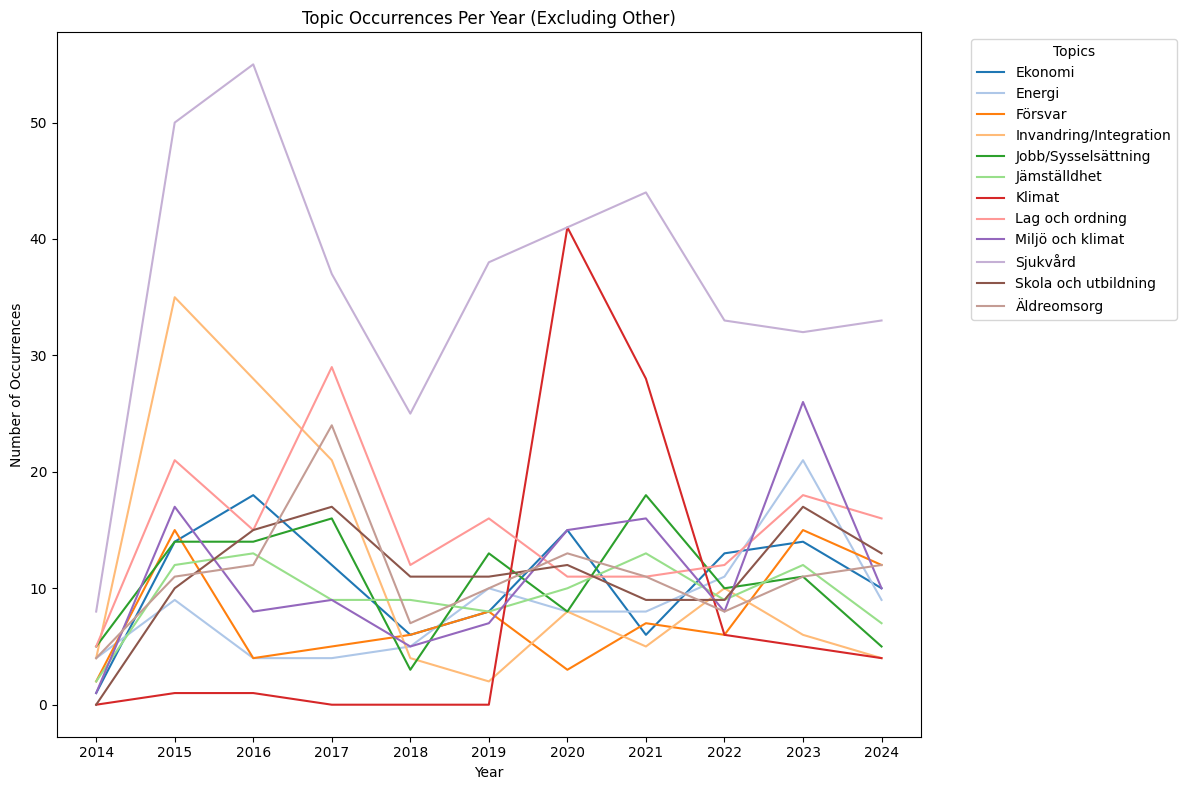

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap

# Group by year and topic, then count occurrences
topic_year_counts = df_cleaned.groupby(['dok_datum', 'guided_topic_name']).size().reset_index(name='count')

# Exclude "Other" from the data
topic_year_counts = topic_year_counts[topic_year_counts['guided_topic_name'] != "Other"]

# Pivot data for plotting
pivot_data = topic_year_counts.pivot(index='dok_datum', columns='guided_topic_name', values='count').fillna(0)

# Use a colormap for distinct colors
cmap = get_cmap("tab20")  # Use "tab20", "tab10", or "viridis" for better color differentiation
colors = [cmap(i) for i in range(len(pivot_data.columns))]

# Plot the data with distinct colors
plt.figure(figsize=(12, 8))

for i, topic in enumerate(pivot_data.columns):
    plt.plot(pivot_data.index, pivot_data[topic], label=topic, color=colors[i])

plt.title('Topic Occurrences Per Year (Excluding Other)')
plt.xlabel('Year')
plt.ylabel('Number of Occurrences')
plt.legend(title='Topics', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [99]:
topic_info = topic_model.get_topic_info()
print(topic_info)

    Topic  Count                                               Name  \
0      -1    376             -1_svar_interpellation_forts_riskgrupp   
1       0    141               0_polis_våld_gängkriminalitet_straff   
2       1     86        1_sverige_svensk_skatteavtal_coronastrategi   
3       2     86  2_invandring_arbetskraftsinvandring_migration_...   
4       3     85     3_utbildning_skola_gymnasielag_lärarutbildning   
5       4     59         4_samarbete_militär_nordisk_internationell   
6       5     59                  5_malus_bonus_svar_interpellation   
7       6     57           6_skog_grön_taxonomiförordning_naturvård   
8       7     56  7_arbetslöshet_arbetsförmedling_arbetsmarknad_...   
9       8     46             8_vindkraft_elnät_elförsörjning_energi   
10      9     39   9_äldreomsorg_funktionsnedsättning_sjukvård_vård   
11     10     39    10_riksrevision_rapport_företag_regelförenkling   
12     11     37               11_pandemin_pandemilag_pandemi_covid   
13    

In [100]:
import pandas as pd

# Convert to a DataFrame for better visualization
topic_counts_df = topic_counts.reset_index()
topic_counts_df.columns = ['Topic', 'Count']
display(topic_counts_df)


,Topic,Count
0,-1,354
1,Sjukvård,121
2,Lag och ordning,86
3,Invandring/Integration,86
4,Skola och utbildning,74
5,Äldreomsorg,62
6,Miljö och klimat,60
7,Jobb/Sysselsättning,55
8,Ekonomi,52
9,Jämställdhet,46


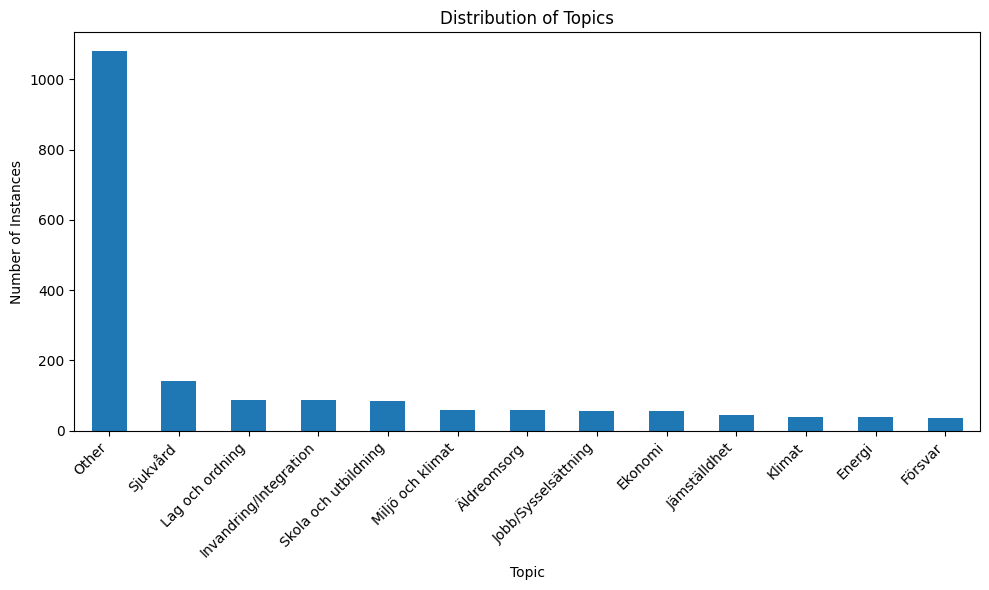

In [103]:
import matplotlib.pyplot as plt

# Count the occurrences of each topic
topic_counts = df_cleaned['guided_topic_name'].value_counts()

# Plot a bar chart
plt.figure(figsize=(10, 6))
topic_counts.plot(kind='bar')
plt.title('Distribution of Topics')
plt.xlabel('Topic')
plt.ylabel('Number of Instances')
plt.xticks(rotation=45, ha='right')  # Rotate topic names for better readability
plt.tight_layout()
plt.show()


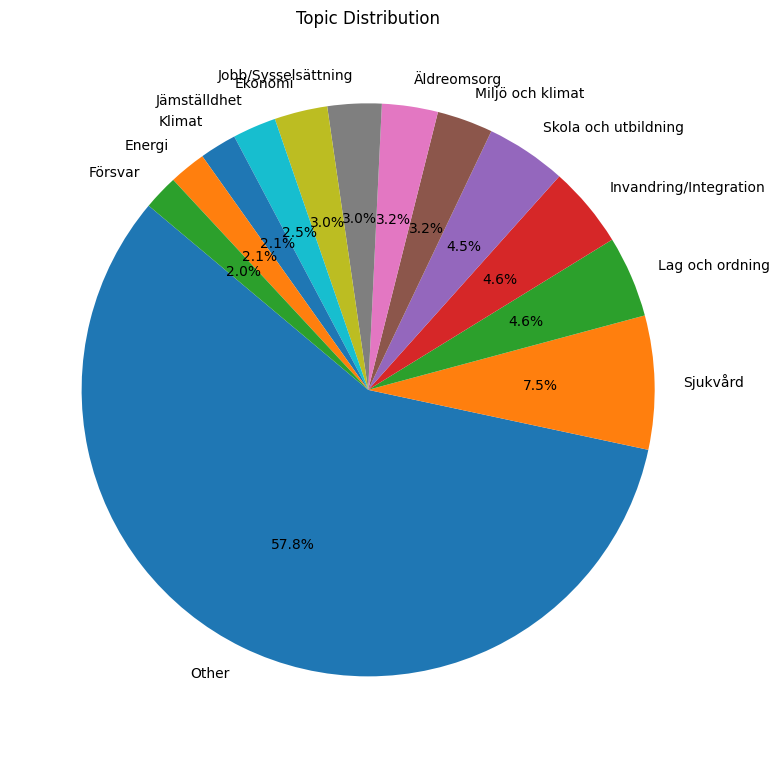

In [104]:
# Plot a pie chart
plt.figure(figsize=(8, 8))
topic_counts.plot(kind='pie', autopct='%1.1f%%', startangle=140)
plt.title('Topic Distribution')
plt.ylabel('')  # Hide the y-axis label for aesthetics
plt.tight_layout()
plt.show()
